# COURSE: A deep understanding of deep learning
## SECTION: Measuring model performance
### LECTURE: APRF example 1: wine quality
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/dudl/?couponCode=202111

In [24]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

# Import and process the data

In [25]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200] # drop a few outliers

# z-score all columns except for quality
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

# create a new column for binarized (boolean) quality
data['boolQuality'] = 0
# data['boolQuality'][data['quality']<6] = 0 # implicit in the code! just here for clarity
data['boolQuality'][data['quality']>5] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [26]:
# convert from pandas dataframe to tensor
dataT  = torch.tensor( data[cols2zscore].values ).float()
labels = torch.tensor( data['boolQuality'].values ).float()
labels = labels[:,None] # transform to matrix

# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = torch.utils.data.TensorDataset(train_data,train_labels)
test_dataDataset  = torch.utils.data.TensorDataset(test_data,test_labels)

# finally, create dataloaders
train_loader = DataLoader(train_dataDataset,batch_size=32, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])

# Now for the DL part

In [27]:
# create a class for the model

class ANNwine(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(11,16)
    
    ### hidden layers
    self.fc1 = nn.Linear(16,32)
    self.fc2 = nn.Linear(32,32)

    ### output layer
    self.output = nn.Linear(32,1)
  
  # forward pass
  def forward(self,x):
    x = F.relu( self.input(x) )
    x = F.relu( self.fc1(x) )
    x = F.relu( self.fc2(x) )
    return self.output(x) # note that sigmoid is not used, done like that for later ARPF calc

# A function to train the model

In [31]:
# global parameter
numepochs = 200

def trainTheModel(winenet):

  # loss function and optimizer
  lossfun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.Adam(winenet.parameters(),lr=.01)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = winenet(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute training accuracy for this batch
      batchAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = winenet(X)
    testAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
  
  # function output
  return trainAcc,testAcc,losses,winenet

# Now to create the fitted model

In [22]:
# create and train a model
winenet = ANNwine()
trainAcc,testAcc,losses = trainTheModel()


TypeError: ignored

# Compute the performance measures on the train and test data

In [ ]:
# predictions for training data
train_predictions = winenet(train_loader.dataset.tensors[0])
train_predictions

# predictions for test data
test_predictions = winenet(test_loader.dataset.tensors[0])
test_predictions

In [ ]:
# NEW! using scikitlearn to compute ARPF
import sklearn.metrics as skm

# initialize vectors
train_metrics = [0,0,0,0]
test_metrics  = [0,0,0,0]

# training
train_metrics[0] = skm.accuracy_score (train_loader.dataset.tensors[1],train_predictions>0)
train_metrics[1] = skm.precision_score(train_loader.dataset.tensors[1],train_predictions>0)
train_metrics[2] = skm.recall_score   (train_loader.dataset.tensors[1],train_predictions>0)
train_metrics[3] = skm.f1_score       (train_loader.dataset.tensors[1],train_predictions>0)


# test
test_metrics[0] = skm.accuracy_score (test_loader.dataset.tensors[1],test_predictions>0)
test_metrics[1] = skm.precision_score(test_loader.dataset.tensors[1],test_predictions>0)
test_metrics[2] = skm.recall_score   (test_loader.dataset.tensors[1],test_predictions>0)
test_metrics[3] = skm.f1_score       (test_loader.dataset.tensors[1],test_predictions>0)

In [ ]:
plt.bar(np.arange(4)-.1,train_metrics,.5)
plt.bar(np.arange(4)+.1,test_metrics,.5)
plt.xticks([0,1,2,3],['Accuracy','Precision','Recall','F1-score'])
plt.ylim([.6,1])
plt.legend(['Train','Test'])
plt.title('Performance metrics')
plt.show()

In [ ]:
# Confusion matrices
trainConf = skm.confusion_matrix(train_loader.dataset.tensors[1],train_predictions>0)
testConf  = skm.confusion_matrix(test_loader.dataset.tensors[1], test_predictions>0)

fig,ax = plt.subplots(1,2,figsize=(10,4))

# confmat during TRAIN
ax[0].imshow(trainConf,'Blues',vmax=len(train_predictions)/2)
ax[0].set_xticks([0,1])
ax[0].set_yticks([0,1])
ax[0].set_xticklabels(['bad','good'])
ax[0].set_yticklabels(['bad','good'])
ax[0].set_xlabel('Predicted quality')
ax[0].set_ylabel('True quality')
ax[0].set_title('TRAIN confusion matrix')

# add text labels
ax[0].text(0,0,f'True negatives:\n{trainConf[0,0]}' ,ha='center',va='center')
ax[0].text(0,1,f'False negatives:\n{trainConf[1,0]}',ha='center',va='center')
ax[0].text(1,1,f'True positives:\n{trainConf[1,1]}' ,ha='center',va='center')
ax[0].text(1,0,f'False positives:\n{trainConf[0,1]}',ha='center',va='center')




# confmat during TEST
ax[1].imshow(testConf,'Blues',vmax=len(test_predictions)/2)
ax[1].set_xticks([0,1])
ax[1].set_yticks([0,1])
ax[1].set_xticklabels(['bad','good'])
ax[1].set_yticklabels(['bad','good'])
ax[1].set_xlabel('Predicted quality')
ax[1].set_ylabel('True quality')
ax[1].set_title('TEST confusion matrix')

# add text labels
ax[1].text(0,0,f'True negatives:\n{testConf[0,0]}' ,ha='center',va='center')
ax[1].text(0,1,f'False negatives:\n{testConf[1,0]}',ha='center',va='center')
ax[1].text(1,1,f'True positives:\n{testConf[1,1]}' ,ha='center',va='center')
ax[1].text(1,0,f'False positives:\n{testConf[0,1]}',ha='center',va='center')
plt.show()

trainConf

# Code Challenge: Xavier vs. Kaiming

In [32]:
# Kaiming initialization

winenet_K = ANNwine()
trainAcc_K,testAcc_K,losses_K,winenet_K = trainTheModel(winenet_K)

# Xavier initialization

winenet_X = ANNwine()
# change the weights (leave biases as Kaiming [default])
for p in winenet_X.named_parameters():
  if 'weight' in p[0]:
    nn.init.xavier_normal_(p[1].data)

trainAcc_X,testAcc_X,losses_X,winenet_X = trainTheModel(winenet_X)


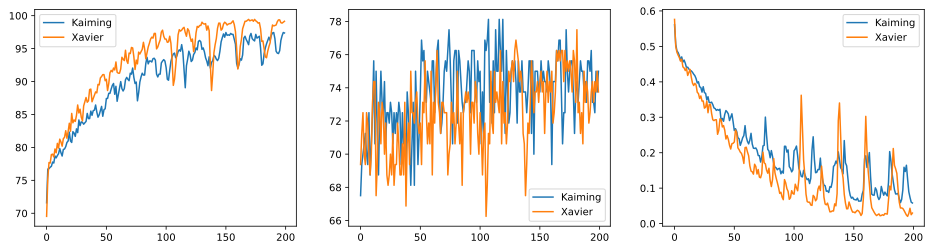

In [33]:
fig,ax = plt.subplots(1,3,figsize = (16,4))

ax[0].plot(trainAcc_K)
ax[0].plot(trainAcc_X)
ax[0].legend(['Kaiming','Xavier'])

ax[1].plot(testAcc_K)
ax[1].plot(testAcc_X)
ax[1].legend(['Kaiming','Xavier'])

ax[2].plot(losses_K)
ax[2].plot(losses_X)
ax[2].legend(['Kaiming','Xavier'])

In [ ]:
testAcc_X

# Experiment

In [35]:
K_data = torch.zeros((10,3,200)) # experiments, train/test/loss, epochs
X_data = torch.zeros((10,3,200))

for k in range(10):
  winenet_K = ANNwine()
  trainAcc_K,testAcc_K,losses_K,winenet_K = trainTheModel(winenet_K)

  winenet_X = ANNwine()
  # change the weights (leave biases as Kaiming [default])
  for p in winenet_X.named_parameters():
    if 'weight' in p[0]:
      nn.init.xavier_normal_(p[1].data)
  trainAcc_X,testAcc_X,losses_X,winenet_X = trainTheModel(winenet_X)

  K_data[k,0,:] = torch.tensor([trainAcc_K])
  K_data[k,1,:] = torch.tensor([testAcc_K])
  K_data[k,2,:] = losses_K

  X_data[k,0,:] = torch.tensor([trainAcc_X])
  X_data[k,1,:] = torch.tensor([testAcc_X])
  X_data[k,2,:] = losses_X

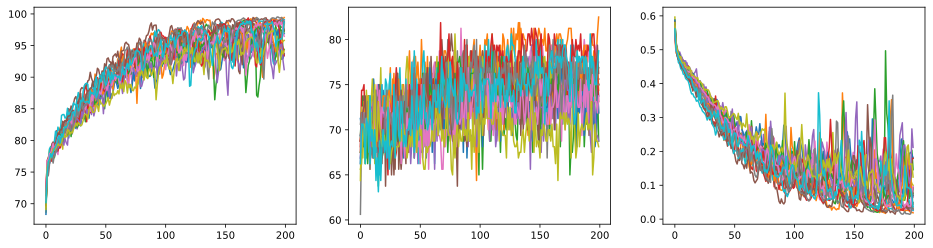

In [38]:
fig,ax = plt.subplots(1,3,figsize = (16,4))


for k in range(10):
  ax[0].plot(K_data[k,0,:],label = f'Kaiming {k}')
  ax[0].plot(X_data[k,0,:],label = f'Xavier {k}')

  ax[1].plot(K_data[k,1,:],label = f'Kaiming {k}')
  ax[1].plot(X_data[k,1,:],label = f'Xavier {k}')

  ax[2].plot(K_data[k,2,:],label = f'Kaiming {k}')
  ax[2].plot(X_data[k,2,:],label = f'Xavier {k}')



In [40]:
results = torch.zeros((10,3,2))

for k in range(10):
  results[k,0,0] = torch.mean(K_data[k,0,-5:])
  results[k,1,0] = torch.mean(K_data[k,1,-5:])
  results[k,2,0] = torch.mean(K_data[k,2,-5:])

  results[k,0,1] = torch.mean(X_data[k,0,-5:])
  results[k,2,1] = torch.mean(X_data[k,1,-5:])
  results[k,2,1] = torch.mean(X_data[k,2,-5:])

In [41]:
metric = ['train','test','loss']
for i in range(3):
  t,p = stats.ttest_ind(results[:,i,1],results[:,i,0])
  print(f'{metric[i]}: t = {t}, p = {p}')

train: t = 2.6472432185706953, p = 0.016384044449486948
test: t = -80.42883521877266, p = 1.811329580193134e-24
loss: t = -2.5731505708786777, p = 0.019148841490719607


# Additional explorations

In [ ]:
# 1) The confusion matrices are rotated, in the sense that most visualizations (outside of Python) have reality in the columns
#    and predictions in the rows. Change the code to get the matrices in the orientation shown in the slides. Make sure
#    all the labels are correct! (hint: you might need to consult the help file: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)
# 
# 2) Normalize the confusion matrix to 'all' (the total N). The numbers are so long that they're difficult to read! Change
#    the text drawing code to transform the proportion into percent, and show only the first 2 digits after the period.
# 